In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [ ]:
# Raw Data
#df = pd.read_csv('rating.csv')
#df.head(5)

In [4]:
# Train Data (subset of all interactions)
df = pd.read_csv('VendaClienteProduto_Abr2020_Abr2021_OC.csv',sep=';',names=['user_id','content_id','view'])

df


,user_id,content_id,view
0,userId,productId,quant
1,254,NaN,0.000
2,3372,NaN,0.000
3,203854,NaN,0.000
4,203998,NaN,0.000
...,...,...,...
235024,150175,79255,1.000
235025,205008,42691,2.000
235026,36298,58852,1.000
235027,66884,75694,2.000


In [ ]:
#Pegar um dataframe menor
shuffled = df.sample(frac=1)
result = np.array_split(shuffled, 3)
df=pd.DataFrame(result[0])
df

,user_id,content_id,view
98751,62986,NaN,0.0
51125,111349,NaN,0.0
33427,201166,NaN,0.0
149487,14744,NaN,0.0
219072,212501,99490.0,1.0
...,...,...,...
34207,172285,NaN,0.0
219013,206214,85545.0,1.0
137862,179984,NaN,0.0
89231,7504,NaN,0.0


In [ ]:
#Pegar apenas diferente de zero
df = df.loc[df['view']!=0]
#df.drop_duplicates(subset='content_id')
#df.set_index(['user_id', 'content_id', 'view'], append=True)
df = df.drop_duplicates(['user_id','content_id'])
df

,user_id,content_id,view
219072,212501,99490.0,1.0
216912,204890,86681.0,1.0
218862,1436,84251.0,1.0
193323,47569,81572.0,1.0
230066,5050,94808.0,1.0
...,...,...,...
201328,67635,99243.0,1.0
221749,8543,87962.0,1.0
205521,128755,10225.0,2.0
231055,941,65613.0,1.0


In [ ]:
# Content Data of Games
#df_game = pd.read_csv('articles_df.csv')
#df_game.head(4)

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9


### Create a Matrix of Interactions

In [ ]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = df.pivot(index   = 'user_id', 
                                 columns = 'content_id', 
                                 values  = 'view').fillna(0)
users_items_matrix_df

content_id,1.0,2.0,10056.0,10057.0,10070.0,10071.0,10072.0,10083.0,10084.0,10098.0,10128.0,10129.0,10171.0,10175.0,10180.0,10195.0,10200.0,10208.0,10225.0,10230.0,10240.0,10241.0,10276.0,10305.0,10314.0,10315.0,10327.0,10360.0,10382.0,10432.0,10437.0,10447.0,10448.0,10451.0,10643.0,10649.0,10650.0,10656.0,10658.0,10660.0,...,104007.0,104076.0,104086.0,104092.0,104133.0,104207.0,104210.0,104213.0,104216.0,104217.0,104222.0,104223.0,104225.0,104229.0,104285.0,104311.0,104313.0,104365.0,104383.0,104387.0,104389.0,104398.0,104399.0,104471.0,104511.0,104513.0,104541.0,104657.0,104668.0,104766.0,104783.0,104838.0,104872.0,104954.0,104975.0,104996.0,105011.0,105092.0,105222.0,105569.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_items_matrix_df.shape

(10171, 6040)

In [ ]:
users_items_matrix_df.values.mean()*100

0.03349511433949659

## Model

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
# input
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [ ]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 6040)]            0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               3092992   
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 6040)              3098520   
Total params: 6,454,424
Trainable params: 6,454,424
Non-trainable params: 0
___________________________________________________

### Train Model

In [ ]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)

Epoch 1/50
144/144 [==============================] - 13s 86ms/step - loss: 0.0132 - val_loss: 0.0325
Epoch 2/50
144/144 [==============================] - 12s 82ms/step - loss: 0.0051 - val_loss: 0.0322
Epoch 3/50
144/144 [==============================] - 12s 81ms/step - loss: 0.0077 - val_loss: 0.0320
Epoch 4/50
144/144 [==============================] - 12s 80ms/step - loss: 0.0034 - val_loss: 0.0319
Epoch 5/50
144/144 [==============================] - 12s 80ms/step - loss: 0.0069 - val_loss: 0.0318
Epoch 6/50
144/144 [==============================] - 12s 80ms/step - loss: 0.0055 - val_loss: 0.0318
Epoch 7/50
144/144 [==============================] - 12s 81ms/step - loss: 0.0027 - val_loss: 0.0317
Epoch 8/50
144/144 [==============================] - 12s 81ms/step - loss: 0.0136 - val_loss: 0.0317
Epoch 9/50
144/144 [==============================] - 11s 80ms/step - loss: 0.0074 - val_loss: 0.0317
Epoch 10/50
144/144 [==============================] - 12s 80ms/step - loss: 0.002

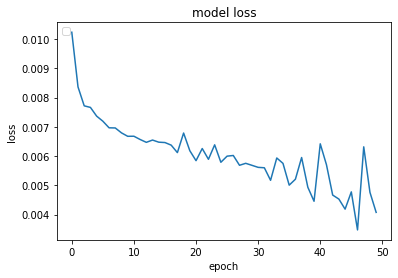

In [ ]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [ ]:
# Predict new Matrix Interactions, set score zero on visualized games
new_matrix = model.predict(X) * (X == 0)

In [ ]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

content_id,1.0,2.0,10056.0,10057.0,10070.0,10071.0,10072.0,10083.0,10084.0,10098.0,10128.0,10129.0,10171.0,10175.0,10180.0,10195.0,10200.0,10208.0,10225.0,10230.0,10240.0,10241.0,10276.0,10305.0,10314.0,10315.0,10327.0,10360.0,10382.0,10432.0,10437.0,10447.0,10448.0,10451.0,10643.0,10649.0,10650.0,10656.0,10658.0,10660.0,...,104007.0,104076.0,104086.0,104092.0,104133.0,104207.0,104210.0,104213.0,104216.0,104217.0,104222.0,104223.0,104225.0,104229.0,104285.0,104311.0,104313.0,104365.0,104383.0,104387.0,104389.0,104398.0,104399.0,104471.0,104511.0,104513.0,104541.0,104657.0,104668.0,104766.0,104783.0,104838.0,104872.0,104954.0,104975.0,104996.0,105011.0,105092.0,105222.0,105569.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,-0.001391,-0.001923,0.005634,0.003190,-0.003361,-0.003749,0.002952,-0.001043,0.006888,-0.003888,0.003603,-0.003755,0.003142,-0.007053,0.004217,0.002349,0.005281,-0.000176,0.011029,-0.002833,-0.001709,0.004439,-0.003224,0.007420,-0.003835,0.005365,0.006225,0.005593,0.000283,0.003150,0.017213,-0.000808,-0.002999,0.016592,0.003994,-0.005887,-0.004205,0.005404,-0.001191,0.005437,...,-0.003067,-0.000831,0.006498,-0.002364,-0.003386,-0.003271,0.003275,0.001765,0.002533,-0.004991,0.001562,0.006529,0.003697,-0.005293,0.001763,-0.000913,-0.003483,0.000728,-0.000621,0.000482,-0.003520,-0.008341,0.003955,-0.000002,0.002699,0.002180,-0.002917,0.005317,-0.000370,-0.002334,0.001159,-0.001350,-0.003201,-0.006391,0.000181,-0.005088,-0.000295,-0.002431,0.001565,-0.001262
247,0.000000,-0.000518,0.003203,0.001549,0.000227,-0.005469,0.001776,-0.000199,0.004978,-0.002336,0.000701,0.000587,0.001309,-0.003656,0.002532,0.001152,0.000338,-0.003481,0.008729,-0.002405,0.001381,0.003199,-0.002757,0.006618,-0.003861,0.005142,0.003343,0.003562,-0.001511,0.003059,0.012469,-0.001579,0.001343,0.013629,0.003849,-0.010014,-0.004560,0.004922,0.001861,0.001835,...,-0.001985,-0.001306,0.001455,-0.001121,-0.005607,0.004244,0.002363,0.000230,0.002626,-0.007046,-0.001752,0.002617,0.003944,-0.003954,0.003370,-0.001656,-0.001395,0.001264,0.001076,-0.001381,-0.004447,-0.003135,0.001533,0.001370,0.007891,0.004098,0.000670,0.002445,-0.001384,-0.000621,-0.001507,0.000086,-0.004097,-0.004073,-0.000641,-0.002043,0.001195,-0.004540,0.001136,-0.000062
250,-0.000292,-0.002392,0.004742,0.003687,-0.002453,-0.005629,0.002307,-0.000250,0.006603,-0.000891,0.000240,-0.004691,0.003988,-0.005090,0.000678,0.003221,0.005672,-0.001804,0.011542,-0.004163,-0.002025,0.003659,-0.001460,0.006978,-0.002687,0.005847,0.006862,0.005915,-0.000185,0.004545,0.017770,-0.000903,-0.004160,0.013534,0.001875,-0.004938,-0.006531,0.005776,-0.001126,0.002693,...,-0.004779,-0.001467,0.007421,-0.002429,-0.002419,-0.001521,0.003795,0.001289,0.002326,-0.006428,0.003174,0.003633,0.003159,-0.003482,0.001787,-0.002978,-0.003711,0.001130,-0.000690,-0.000409,-0.003313,-0.006475,0.002880,-0.000705,0.002765,0.003639,-0.001495,0.003734,-0.000396,-0.000529,0.000693,-0.001054,-0.002791,-0.006722,-0.000200,-0.003989,-0.003091,-0.003527,0.001108,-0.000472
273,0.001625,-0.003370,0.005771,0.002536,-0.001617,-0.005228,0.002693,-0.001220,0.007146,-0.002529,0.002813,-0.003188,0.004141,-0.005411,0.003326,0.003565,0.004848,0.001147,0.011315,-0.002569,-0.001436,0.005616,-0.003829,0.007639,-0.003094,0.005689,0.005494,0.006319,0.000319,0.004142,0.015653,-0.000455,-0.003120,0.012251,0.003385,-0.006033,-0.004123,0.005145,-0.002968,0.003724,...,-0.003223,-0.002007,0.006407,-0.002472,-0.001608,-0.001175,0.004923,0.004186,0.002114,-0.006648,0.002161,0.003399,0.006427,-0.004135,0.003713,-0.002427,-0.005624,0.000083,0.000231,-0.001485,-0.002899,-0.006018,0.003823,0.001398,0.004532,0.003885,-0.000938,0.003224,-0.002724,-0.002923,0.000068,-0.000337,-0.004229,-0.006858,0.000100,-0.006405,0.000657,-0.001706,0.002120,-0.003046
274,-0.001565,-0.000211,0.006050,0.006275,-0.005878,-0.005667,0.002553,0.000784,0.007859,0.000143,-0.003320,-0.007325,0.008183,-0.005030,0.003156,0.003166,0.

In [ ]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())

-9.049887 7.484353


def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    '''
    Recommender Games for UserWarning
    '''
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'content_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('content_id')\
                    .join(df_content.set_index('content_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'game']]
    
    return df_rec[df_rec.score > 0]

In [ ]:
def recommender_for_user(user_id, interact_matrix,  topn = 10):
    '''
    Recommender Games for UserWarning
    '''
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'content_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('content_id')\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score']]
    
    return df_rec[df_rec.score > 0]

Recommender for **user_id = 1011**. This user prefers games in the same half-life line

# Games previously purchased by the user
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

In [ ]:
# Games previously purchased by the user
print('Digite cod. do usuário:')
x=input()
recommender_for_user(
    user_id         = 29, 
    interact_matrix = users_items_matrix_df)


Digite cod. do usuário:
212883


,score
content_id,
81065.0,1.0
